In [1]:
from itertools import product, combinations
import matplotlib.pyplot as plt
import numpy as np
from src import k_tree
from src.utils import data as dt
import torch
from src.k_tree import Ktree
from src.utils.data import loadData, loadData_3d
from src.metrics import Linf_simple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
data, _ = loadData(10000)
#device = "cpu"
#device = "cpu"
#data, _ = loadData(100)
#data = squares


#data = rects
learning_rate = 5e-3 # 1e-2, 5e-3
k = 3
teacher_args = {
    "optimizer_lr": learning_rate,
    "epochs": 400, # 300
    "times": 20,
    "alpha": 0.1, #  projection loss 0.1
    "beta": 0.1, # latent loss 0.1
    "gamma": 0.011, # repulsive loss 0.01
    #"gamma": 0.4, # repulsive loss 0.01
    "delta": 0.1, # fuzzy scale 0.01
    "f_clk": 10, # 20
    "scale": 1, # fuzzy scale 
    "scale_flag": False,
    "number_of_centroids": k,
    "latent_size": 200,
    "encoder_activation": False,
    "encoder_depth": 5,
    "predictor_width": 5*100,
    "predictor_depth": 5,
}
n = 30
un_args = {
    "N": n,
    "M": n**2-1, # 10000 - 1
    "epsilon": 0.15 # here a layer value should be somehow included. As layers get denser  epilson should be smaller
}
student_args = {
    "optimizer_lr": 5e-3,
    "epochs": 3000, # 30000, 3000
    "width": 200,
    "depth": 5,
}


thresshold = 100*k
metric = Linf_simple
ktree = Ktree(thresshold, data, metric,teacher_args, un_args, student_args,device=device)
ktree.create_tree(plot=False)
#path = 'models/squares/100/class0_student_config.pt'
#ktree.root.create_student_from_config(path)





Loading data...
Data loaded.

Creating student for node 0 that has 9999 data, which is more than the threshold 300.
Bounding box for node 0: [[-5, 7008], [-8, 7008]]
Creating teacher for node 0 with 3 centroids.
Training Teacher Model
Shuffling data


/home/geoten/Projects/GeoCluster/src/geometry.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rotation = torch.tensor(rotation)


Epoch: 20/400.. 
 Training loss: 2153.08740.. 
 torch.mean(F): 2015.95959.. 
 Reg Proj: 128.15283.. 
 Reg Latent: 8.97501.. 
 Repulsive: 0.00003.. 
 Memory: 201.59596.. 
 Memory: 201.59596.. 
 Output: 
 [[4011.7185 3211.9307]
 [5203.9644 4168.4233]
 [7648.764  6125.1045]]
Epoch: 40/400.. 
 Training loss: 1940.58276.. 
 torch.mean(F): 1929.95728.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 10.62548.. 
 Repulsive: 0.00005.. 
 Memory: 192.99573.. 
 Memory: 192.99573.. 
 Output: 
 [[1229.4246 1104.086 ]
 [2406.0813 2161.4592]
 [3623.9749 3255.5195]]
Epoch: 60/400.. 
 Training loss: 1692.18884.. 
 torch.mean(F): 1678.02808.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 14.16071.. 
 Repulsive: 0.00003.. 
 Memory: 167.80281.. 
 Memory: 167.80281.. 
 Output: 
 [[1845.8113 1953.0101]
 [3542.9434 3748.7068]
 [5283.7676 5590.642 ]]
Epoch: 80/400.. 
 Training loss: 1760.72888.. 
 torch.mean(F): 1745.88660.. 
 Reg Proj: 0.00000.. 
 Reg Latent: 14.84224.. 
 Repulsive: 0.00003.. 
 Memory: 174.58866.. 
 Memory: 174.5

In [2]:
# Report some tree stats.
leaves = ktree.get_leaves()
number_of_nodes = ktree.number_of_nodes

height = max([len(leaf.index) for leaf in leaves])
print(f"Tree height is {height}.")

leaf_sizes = [len(leaf.data) for leaf in leaves]
print(f"Created {len(leaves)} leaves with sizes")
print(leaf_sizes)
print(number_of_nodes)

Tree height is 6.
Created 26 leaves with sizes
[343, 89, 265, 48, 314, 128, 137, 173, 200, 239, 235, 174, 197, 951, 700, 102, 415, 571, 396, 909, 923, 654, 364, 764, 378, 330]
44


The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The mean percentage of correct predictions is: 
[0. 0. 0. 0. 0. 0.]


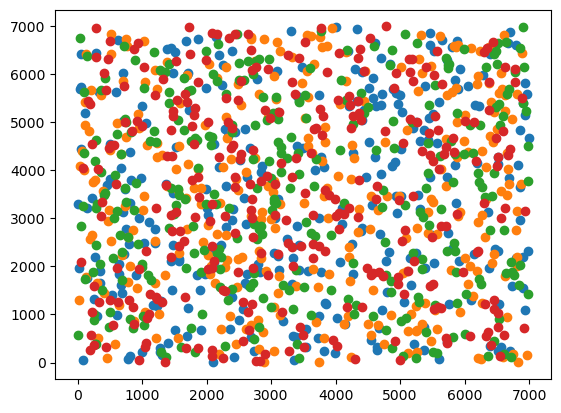

In [3]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0
while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [min(data[:, 0]), max(data[:, 0])]
    y_lim = [min(data[:, 1]), max(data[:, 1])]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(x_lim[0],x_lim[1]), np.random.randint(y_lim[0],y_lim[1])])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=1)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred, k_nearest_neighbors[ki]) for ki in range(1)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The percentage of correct predictions per layer is: 
[0. 0. 0. 0. 0. 0.]
The mean percentage of correct predictions is: 
[0. 0. 0. 0. 0. 0.]


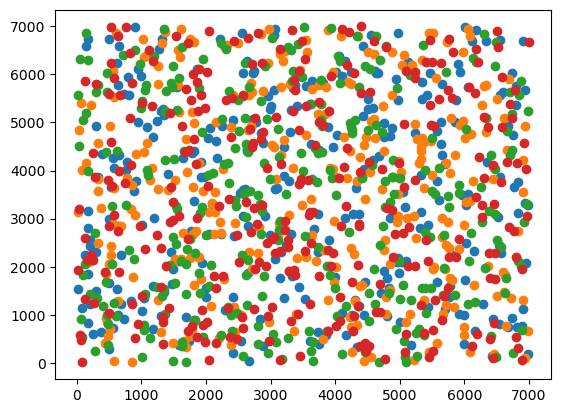

In [4]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0
while times < 4:
    # now lets create randomly N points in the space 0-300, 0-300
    n = 300
    random_p = torch.zeros(n, 2)
    x_lim = [min(data[:, 0]), max(data[:, 0])]
    y_lim = [min(data[:, 1]), max(data[:, 1])]


    for i in range(n):
        random_p[i] = torch.Tensor([np.random.randint(x_lim[0],x_lim[1]), np.random.randint(y_lim[0],y_lim[1])])
        
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        k_nearest_neighbors = ktree.root.query(query_point, k=2)

        for j, pred in enumerate(preds_per_layer):
            if any(np.array_equal(pred, k_nearest_neighbors[ki]) for ki in range(2)):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)

The percentage of correct predictions per layer is: 
[94.  84.8 64.  54.4 20.2  2.4]
The mean percentage of correct predictions is: 
[94.  84.8 64.  54.4 20.2  2.4]


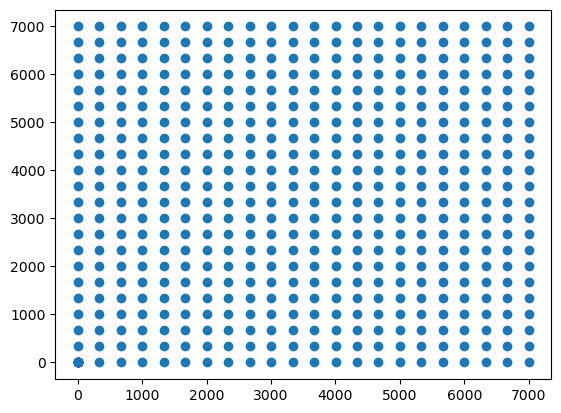

In [5]:
import numpy as np
import matplotlib.pyplot as plt
mean_acc_per_layer = np.zeros(height)
times=0

while times < 1:
    nop =  500
    random_p = torch.zeros(nop, 2)
    x_lim = [min(data[:, 0]), max(data[:, 0])]
    y_lim = [min(data[:, 1]), max(data[:, 1])]
    num = int(np.sqrt(nop))
    for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], num)):
        for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], num)):
            random_p[i*num+j] = torch.Tensor([x, y])
    
    infer_points = random_p.to(device)
    plt.scatter(infer_points[:,0], infer_points[:,1])

    correct_predictions_per_layer = np.zeros(height)
    accuracy_per_layer = np.zeros(height)

    qp = infer_points
    for i, query_point in enumerate(qp):
        preds_per_layer = ktree.query_verbose(query_point)["predictions per layer"]
        brute_force = ktree.root.query(query_point)

        for j, pred in enumerate(preds_per_layer):
            if np.array_equal(pred, brute_force):
                correct_predictions_per_layer[j] += 1

    accuracy_per_layer = correct_predictions_per_layer / len(infer_points) * 100
    mean_acc_per_layer += accuracy_per_layer
    times += 1
    print(f"The percentage of correct predictions per layer is: ")
    print(accuracy_per_layer)

print(f"The mean percentage of correct predictions is: ")
print(mean_acc_per_layer/times)